# 量子费舍信息

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

本教程简要介绍经典费舍信息（classical Fisher information, CFI）和量子费舍信息（quantum Fisher information, QFI）的概念及其在量子机器学习中的应用，并展示如何调用量桨来计算它们。

## 背景

量子费舍信息这一概念源自量子传感领域，现已逐渐成为研究参数化量子系统的通用工具 [[1]](https://arxiv.org/abs/2103.15191)，例如描述过参数化现象 [[2]](https://arxiv.org/abs/2102.01659)，量子自然梯度下降 [[3]](https://arxiv.org/abs/1909.02108) 等。量子费舍信息是经典费舍信息在量子系统中的自然类比。经典费舍信息刻画了一个参数化的『概率分布』对其参数变化的灵敏度，而量子费舍信息刻画了一个参数化的『量子态』对其参数变化的灵敏度。

按照传统的介绍方式，经典费舍信息会作为数理统计中参数估计的一部分内容出现，但对于初学者来说可能是复杂且不直观的。本教程将从几何的角度出发来介绍经典费舍信息，这不仅有助于直观理解，且更容易由此看出其与量子费舍信息之间的联系。

### 经典费舍信息

首先介绍经典费舍信息。对于一个参数化的概率分布 $p(\boldsymbol{x};\boldsymbol{\theta})$，考虑如下问题

- 一个轻微的参数改变会在多大程度上造成概率分布的改变？

这是个关于微扰的问题，所以自然地想到做类似泰勒展开的操作。但在此之前，我们需要知道展开哪个函数，即我们需要量化『概率分布的改变』。更正式的说法是，我们需要定义任意两个概率分布之间的『距离』，记为 $d(p(\boldsymbol{x};\boldsymbol{\theta}),p(\boldsymbol{x};\boldsymbol{\theta}'))$，或简记为 $d(\boldsymbol{\theta},\boldsymbol{\theta}')$。

一般地，一个合法的距离定义应该是非负的，当且仅当两点重合时为零，即

$$
\begin{aligned}
&d(\boldsymbol{\theta},\boldsymbol{\theta}')\geq 0,\\
&d(\boldsymbol{\theta},\boldsymbol{\theta}')=0~\Leftrightarrow~\boldsymbol{\theta}=\boldsymbol{\theta}'.
\end{aligned}
\tag{1}
$$

考虑一个很短的距离函数的展开 $d(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})$，以上条件会导致

$$
\begin{aligned}
&d(\boldsymbol{\theta},\boldsymbol{\theta})=0~\Rightarrow~\text{零阶项}=0,\\
&d(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})\geq 0~\Rightarrow~\boldsymbol{\delta}=0~\text{取极小值}
~\Rightarrow~\text{一阶项}=0.
\end{aligned}
\tag{2}
$$

因此，在这个展开中最低阶的非零贡献来自二阶。因此它可被写为

$$
\begin{aligned}
d(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})
=\frac{1}{2}\sum_{ij}\delta_iM_{ij}\delta_j+O(\|\boldsymbol{\delta}\|^3) 
=\frac{1}{2} \boldsymbol{\delta}^T M \boldsymbol{\delta} + O(\|\boldsymbol{\delta}\|^3),
\end{aligned}
\tag{3}
$$

此处

$$
M_{ij}(\boldsymbol{\theta})=\left.\frac{\partial^2}{\partial\delta_i\partial\delta_j}d(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})\right|_{\boldsymbol{\delta}=0},
\tag{4}
$$

正是这个距离函数展开的海森矩阵。在微分几何的框架下，这称作流形的[度规](http://en.wikipedia.org/wiki/Metric_tensor)。以上简单的推导说明，我们总是可以用参数的一个二次型来近似表示一小段距离（如图1）。而二次型的系数矩阵，除了有一个 $1/2$ 因子的差别外，正是距离函数展开的海森矩阵。

![feature map](./figures/FIM-fig-Sphere-metric.png "Figure 1. Approximate a small distance on the 2-sphere as a quadratic form")
<div style="text-align:center">图 1. 将一小段距离近似为二次型，此处以二维球面为例绘制 </div>

如果我们定义概率分布之间的距离为相对熵或称 KL 散度

$$
d_{\mathrm{KL}}(\boldsymbol{\theta}, \boldsymbol{\theta}^{\prime})=\sum_{\boldsymbol{x}} p(\boldsymbol{x};\boldsymbol{\theta}) \log \frac{p(\boldsymbol{x};\boldsymbol{\theta})}{p(\boldsymbol{x};\boldsymbol{\theta}^{\prime})}.
\tag{5}
$$

对应的海森矩阵为

$$
\begin{aligned}
\mathcal{I}_{ij}(\boldsymbol{\theta})&= \left.\frac{\partial^2}{\partial\delta_i\partial\delta_j}d_{\mathrm{KL}}(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})\right|_{\boldsymbol{\delta}=0}\\
&=-\sum_{\boldsymbol{x}} p(\boldsymbol{x};\boldsymbol{\theta}) \partial_{i} \partial_{j} \log p(\boldsymbol{x};\boldsymbol{\theta})
=\mathbb{E}_{\boldsymbol{x}}[-\partial_{i} \partial_{j} \log p(\boldsymbol{x};\boldsymbol{\theta})] \\
&=\sum_{\boldsymbol{x}}  \frac{1}{p(\boldsymbol{x};\boldsymbol{\theta})} \partial_i p(\boldsymbol{x};\boldsymbol{\theta}) \cdot \partial_j p(\boldsymbol{x};\boldsymbol{\theta})
=\mathbb{E}_{\boldsymbol{x}}[\partial_i\log p(\boldsymbol{x};\boldsymbol{\theta})\cdot \partial_j \log p(\boldsymbol{x};\boldsymbol{\theta})].
\end{aligned}
\tag{6}
$$

这就是所谓的经典费舍信息矩阵（classical Fisher information matrix, CFIM），矩阵元越大说明概率分布对相应的参数变化越灵敏。上式中我们使用了偏导数符号的简记 $\partial_i=\partial/\partial \theta_i$。

为什么 $\mathcal{I}(\boldsymbol{\theta})$ 称为『信息』？这是因为，CFIM 刻画了概率分布在对应参数一个领域内的灵敏度，或称锐度。对参数变化越灵敏，说明我们越容易将其同其它概率分布区分开来，进一步地，说明我们需要越少的样本就可以完成这种区分，那么每个样本中平均所含的信息量就越多。

参数化量子电路（parameterized quantum circuit, PQC）的测量结果会形成一个概率分布，因此可以对不同的测量基定义不同的 CFIM。目前在 NISQ 设备上计算 CFIM 的主要挑战是，可能出现的测量结果的数量会随着量子比特数的增加而指数地增加，这意味着可能有很多小概率的测量结果从未出现过，导致 CFIM 的计算出现发散。一些可能的解决方案包括直接忽略小的概率事件，以及贝叶斯更新等 [[1]](https://arxiv.org/abs/2103.15191)。

### 量子费舍信息

量子费舍信息是经典费舍信息的自然类比，只是距离函数不再定义在两个概率分布之间，而是定义在两个量子态之间。我们通常选用保真度距离

$$
d_f(\boldsymbol{\theta},\boldsymbol{\theta}')=2-2|\langle\psi(\boldsymbol{\theta})|\psi(\boldsymbol{\theta}')\rangle|^2.
\tag{7}
$$

此处因子 $2$ 是人为乘上去的，为的是让后续的结果与 CFIM 对应上。一个参数化量子纯态 $|\psi(\boldsymbol{\theta})\rangle, \boldsymbol{\theta}\in\mathbb{R}^m$ 的量子费舍信息矩阵（quantum Fisher information matrix, QFIM）就是保真度距离展开的海森矩阵，即

$$
\begin{aligned}
\mathcal{F}_{ij}(\boldsymbol{\theta})
&= \left.\frac{\partial^2}{\partial\delta_i\partial\delta_j}d_{f}(\boldsymbol{\theta},\boldsymbol{\theta}+\boldsymbol{\delta})\right|_{\boldsymbol{\delta}=0} \\
&=4 \operatorname{Re}\left[\left\langle\partial_{i} \psi \mid \partial_{j} \psi\right\rangle - \left\langle\partial_{i} \psi \mid \psi\right\rangle\left\langle\psi \mid \partial_{j} \psi\right\rangle\right],
\end{aligned}
\tag{8}
$$

上式中简洁起见我们略写了自变量 $\boldsymbol{\theta}$。与 CFIM 类似，QFIM 刻画了参数化量子态对参数微小变化的灵敏度。此外值得一提的是，QFIM 可以被视为另一个被称作量子几何张量的复数矩阵的实部，或称为 Fubini-Study 度规 [[1]](https://arxiv.org/abs/2103.15191)。

目前，人们已经提出了一些在 NISQ 设备上计算纯态 QFIM 的方法，其中最直接的两个方法是

- 利用二阶参数平移规则计算每个矩阵元 [[4]](https://arxiv.org/abs/2008.06517)
$$
\begin{aligned}
\mathcal{F}_{i j}=-\frac{1}{2} \Big(&|\langle\psi(\boldsymbol{\theta}) \mid \psi(\boldsymbol{\theta}+(\boldsymbol{e}_{i}+\boldsymbol{e}_{j}) \frac{\pi}{2})\rangle|^{2}
-|\langle\psi(\boldsymbol{\theta}) \mid \psi(\boldsymbol{\theta}+(\boldsymbol{e}_{i}-\boldsymbol{e}_{j}) \frac{\pi}{2})\rangle|^{2}\\
-&|\langle\psi(\boldsymbol{\theta}) \mid \psi(\boldsymbol{\theta}-(\boldsymbol{e}_{i}-\boldsymbol{e}_{j}) \frac{\pi}{2})\rangle|^{2}
+|\langle\psi(\boldsymbol{\theta}) \mid \psi(\boldsymbol{\theta}-(\boldsymbol{e}_{i}+\boldsymbol{e}_{j}) \frac{\pi}{2})\rangle|^{2}\Big),
\end{aligned}
\tag{9}
$$
其中 $\boldsymbol{e}_{i}$ 是 $\theta_i$ 对应方向的单位向量。值得注意的是，参数平移规则不能直接适用于单比特旋转门的参数间有依赖关系的情况，例如受控旋转门等。

- 利用有限差分计算 QFIM 沿一个确定方向的投影 [[1]](https://arxiv.org/abs/2103.15191)
$$
\boldsymbol{v}^{T} \mathcal{F} \boldsymbol{v} \approx \frac{4 d_{f}(\boldsymbol{\theta}, \boldsymbol{\theta}+\epsilon \boldsymbol{v})}{\epsilon^{2}}.
\tag{10}
$$
这个量可以被视为著名的 Fisher-Rao 模在量子态空间的类比。

对于混态，QFIM 可以类似地通过 Bures 保真度距离的展开来定义

$$
d_B(\boldsymbol{\theta},\boldsymbol{\theta}')\equiv 
2-2\left[\text{Tr}\left([\sqrt{\rho(\boldsymbol{\theta})} \rho(\boldsymbol{\theta}')\sqrt{\rho(\boldsymbol{\theta})}]^{1/2}\right)\right]^2,
\tag{11}
$$

或者等价地（$\log x\sim x-1$），通过如下形式的 $\alpha=1/2$ 的 Rényi 相对熵的展开来定义 [[5]](https://arxiv.org/abs/1308.5961)

$$
\begin{aligned}
d_R(\boldsymbol{\theta},\boldsymbol{\theta}') &\equiv 2\widetilde{D}_{\alpha=1/2}(\rho(\boldsymbol{\theta'}) \| \rho(\boldsymbol{\theta})), \\
\widetilde{D}_{\alpha}(\rho \| \sigma) 
&\equiv 
\frac{1}{\alpha-1} \log \operatorname{Tr}\left[\left(\sigma^{\frac{1-\alpha}{2 \alpha}} \rho \sigma^{\frac{1-\alpha}{2 \alpha}}\right)^{\alpha}\right].\\
\end{aligned}
\tag{12}
$$

更多细节请参考这篇综述 [[1]](https://arxiv.org/abs/2103.15191) 。

### 经典与量子费舍信息的关系

根据定义，对于一个参数化的量子电路，CFIM 依赖于测量基，而 QFIM 不依赖。事实上可以证明，一个量子态 $\rho(\boldsymbol{\theta})$ 的 QFIM 是其在任意测量基下对应 CFIM 的一个上限，即

$$
\mathcal{I}[\mathcal{E}[\rho(\boldsymbol{\theta})]]\leq \mathcal{F}[\rho(\boldsymbol{\theta})],~\forall\mathcal{E},
\tag{13}
$$

此处 $\mathcal{E}$ 表示测量对应的量子操作。正定矩阵间不等式的含义是，大的减去小的结果仍然是一个正定矩阵。由于对量子态的测量永远无法提取出比量子态本身更多的信息，因此上式的成立是很自然的。数学上这根源于保真度距离对于保迹量子操作的单调性 [[1]](https://arxiv.org/abs/2103.15191)。

### 应用：有效维数

经典/量子费舍信息矩阵的秩在参数空间的最大值可以用来衡量神经网络表达能力，称为经典/量子有效维数

$$
d_{\text{eff}}=\underset{\boldsymbol{\theta}\in\Theta} {\max}
\operatorname{rank}{\mathcal{F}}(\boldsymbol{\theta}).
\tag{14}
$$

秩的大小刻画了参数变化会造成概率分布/量子态变化的方向的数量。非满秩意味着有一些特定方向的参数变化不能实际地导致概率分布/量子态发生变化，或者说有一些参数自由度是冗余的，可以把它们从模型中投影掉，因此这种现象被称作过参数化。另一方面，有效维数越大，对应着更多可以延伸的方向，这意味着模型对应的函数空间更大，即表达能力更强。

在机器学习的语境下，『经验费舍信息矩阵』[[6]](https://arxiv.org/abs/2011.00027) 的使用更为广泛，它与 CFIM 的区别是用对样本的求和代替了求期望

$$
\tilde{\mathcal{I}}_{ij}(\boldsymbol{\theta})
=\frac{1}{n}\sum_{k=1}^{n}
\partial_i\log p(x_k,y_k;\boldsymbol{\theta})
\partial_j\log p(x_k,y_k;\boldsymbol{\theta}),
\tag{15}
$$

此处 $(x_k,y_k)^{n}_{k=1}$ 是独立同分布的样本，分布为 $p(x,y;\boldsymbol{\theta})=p(y|x;\boldsymbol{\theta})p(x)$。显然，经验费舍信息矩阵在无限样本的极限下可以回到 CFIM，只要满足（1）模型被训练到全局最优；（2）模型拥有足够的表达能力来表达底层的数据分布。使用经验费舍信息矩阵的优势在于，它可以利用现成的样本直接计算，而不是为了计算公式中的积分而生成新的样本。

利用经验费舍信息矩阵，我们可以定义有效维数的一个变体 

$$
d_{\text{eff}}(\gamma, n)=
2 \frac{\log \left(\frac{1}{V_{\Theta}} \int_{\Theta} \sqrt{\operatorname{det}\left( 1 + \frac{\gamma n}{2 \pi \log n} \hat{\mathcal{I}}( \boldsymbol{\theta})\right)} \mathrm{d}  \boldsymbol{\theta} \right)}
{\log \left(\frac{\gamma n}{2 \pi \log n}\right)},
\tag{16}
$$

其中 $V_{\Theta}:=\int_{\Theta} \mathrm{d} \boldsymbol{\theta} \in \mathbb{R}_{+}$ 是参数空间的体积。$\gamma\in(0,1]$ 是一个人为可调参数。$\hat{\mathcal{I}} (\boldsymbol{\theta}) \in \mathbb{R}^{d\times d}$ 是归一化的经验费舍信息矩阵

$$
\hat{\mathcal{I}}_{i j}(\boldsymbol{\theta}):= \frac{V_{\Theta} d }{\int_{\Theta} \operatorname{Tr}(F( \boldsymbol{\theta} ) \mathrm{d} \theta} \tilde{\mathcal{I}}_{i j}(\boldsymbol{\theta}).
\tag{17}
$$

这个定义乍看起来可能很迷惑，因为它比上文通过秩来定义要复杂得多。然而，它实际上可以在无限样本的极限下 $n\rightarrow \infty$  回到 CFIM 最大秩的定义 [[6]](https://arxiv.org/abs/2011.00027)。若忽略定义中的一些系数和取对数的操作，此处定义的有效维数可以粗略地看作归一化 CFIM 加上一个单位矩阵的本征谱的几何平均。依据几何平均与算术平均间的不等式关系，可知本征谱分布越均匀，有效维数越大。这和我们的直觉是一致的。在这个意义上，它可以看作是一个软化版本的有效维数。

另外，费舍信息不仅可以用来计算模型的表达能力，还可以用来表征模型的可训练性。如果费舍信息矩阵的矩阵元在参数空间的平均随体系规模的增大而指数地趋于零，即概率分布/量子态对参数变化的灵敏度指数地趋于零，那么我们将无法高效地区分它们，也就意味着贫瘠高原现象的存在 [[6]](https://arxiv.org/abs/2011.00027)。

## 调用量桨计算费舍信息

### 计算量子费舍信息

利用量桨工具，通过以下步骤我们就可以方便地算出 QFIM。

1. 调用 `Circuit` 类定义一个量子电路。
2. 调用 `QuantumFisher` 类定义一个 QFIM 计算器。
3. 调用 `get_qfisher_matrix()` 方法计算 QFIM。

其中计算器 `QuantumFisher` 会追踪量子电路 `Circuit` 的实时变化。

现在来着手写代码。首先导入一些必要的包。

In [15]:
import paddle
from paddle_quantum.ansatz import Circuit
import numpy as np
import matplotlib.pyplot as plt
from paddle_quantum.fisher import QuantumFisher, ClassicalFisher
import warnings
warnings.filterwarnings("ignore")

然后定义量子电路。作为一个简单的例子，我们采用布洛赫角表示的单个量子比特

$$
|\psi(\theta,\phi)\rangle=R_z(\phi)R_y(\theta)|0\rangle=e^{-i\phi/2}\cos\frac{\theta}{2}|0\rangle+e^{i\phi/2}\sin\frac{\theta}{2}|1\rangle.
\tag{18}
$$

利用 (8) 式可以计算出对应 QFIM 的解析表达式为

$$
\mathcal{F}(\theta,\phi)=\left(\begin{matrix}
1&0\\
0&\sin^2\theta
\end{matrix}\right).
\tag{19}
$$

In [16]:
def circuit_bloch():
    cir = Circuit(1)
    cir.ry()
    cir.rz()
    return cir

In [17]:
cir = circuit_bloch()
print(cir)

--Ry(2.574)----Rz(6.022)--
                          


定义 QFIM 计算器然后计算不同 $\theta$ 对应的 QFIM 矩阵元 $\mathcal{F}_{\phi\phi}$ 。

In [18]:
qf = QuantumFisher(cir)
# 记录 QFIM 的矩阵元 F_{phi,phi}
list_qfisher_elements = []
num_thetas = 21
thetas = np.linspace(0, np.pi, num_thetas)
for theta in thetas:
    list_param = cir.param.tolist()
    list_param[0] = theta
    cir.update_param(list_param)
    # 计算 QFIM
    qfim = qf.get_qfisher_matrix()
    print(f'The QFIM at {np.array(list_param)} is \n {qfim.round(14)}.')
    list_qfisher_elements.append(qfim[1][1])

The QFIM at [0.         6.02232647] is 
 [[1. 0.]
 [0. 0.]].
The QFIM at [0.15707963 6.02232647] is 
 [[1.00000000e+00 3.87542900e-08]
 [3.87542900e-08 2.44718161e-02]].
The QFIM at [0.31415927 6.02232647] is 
 [[ 1.00000024e+00 -1.25257100e-08]
 [-1.25257100e-08  9.54916961e-02]].
The QFIM at [0.4712389  6.02232647] is 
 [[ 1.00000000e+00 -9.98981000e-08]
 [-9.98981000e-08  2.06107258e-01]].
The QFIM at [0.62831853 6.02232647] is 
 [[1.00000024 0.        ]
 [0.         0.34549158]].
The QFIM at [0.78539816 6.02232647] is 
 [[ 1.00000000e+00 -1.03238260e-07]
 [-1.03238260e-07  5.00000059e-01]].
The QFIM at [0.9424778  6.02232647] is 
 [[ 1.00000024e+00 -5.11963400e-08]
 [-5.11963400e-08  6.54508745e-01]].
The QFIM at [1.09955743 6.02232647] is 
 [[ 1.00000000e+00 -8.24729700e-08]
 [-8.24729700e-08  7.93892649e-01]].
The QFIM at [1.25663706 6.02232647] is 
 [[1.00000024e+00 3.54160800e-08]
 [3.54160800e-08 9.04508740e-01]].
The QFIM at [1.41371669 6.02232647] is 
 [[ 1.00000024e+00 -4.5

画出 $\mathcal{F}_{\phi\phi}$ 随 $\theta$ 变化的图像。

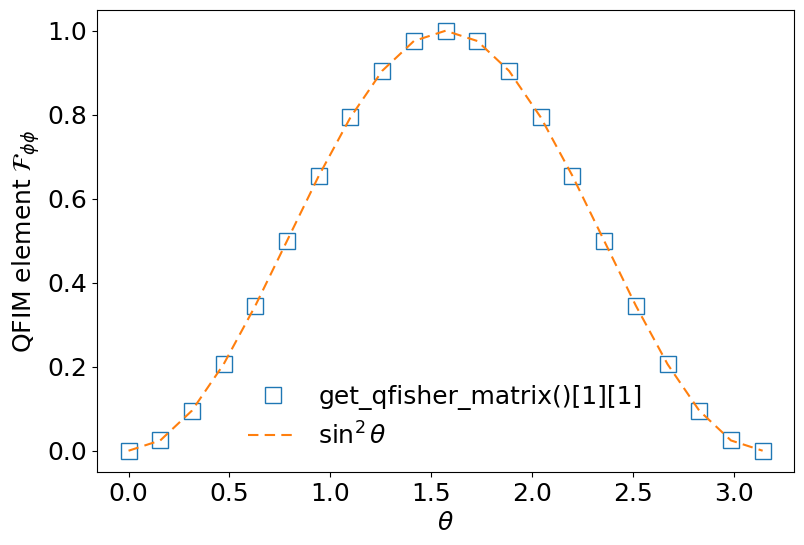

In [19]:
# 创建图像
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
# 绘制 QFIM
ax.plot(thetas, list_qfisher_elements, 's', markersize=11, markerfacecolor='none')
# 绘制 sin^2 theta
ax.plot(thetas, np.sin(thetas) ** 2, linestyle=(0, (5, 3)))
# 设置图例，标签，刻度
label_font_size = 18
ax.legend(['get_qfisher_matrix()[1][1]', '$\\sin^2\\theta$'], 
          prop= {'size': label_font_size}, frameon=False) 
ax.set_xlabel('$\\theta$', fontsize=label_font_size)
ax.set_ylabel('QFIM element $\\mathcal{F}_{\\phi\\phi}$', fontsize=label_font_size)
ax.tick_params(labelsize=label_font_size)

可以看到程序输出和解析结果是一致的。

此外，我们还可以调用 `get_qfisher_norm()` 方法来计算式 (10) 中的量子费舍信息矩阵在某个方向的投影。

举一个和上面不同的例子，两个量子比特上的一个典型的 hardware-efficient 拟设

$$
|\psi(\boldsymbol{\theta})\rangle=\left[R_{y}\left( \theta_{3}\right) \otimes R_{y}\left( \theta_{4}\right)\right] \text{CNOT}_{0,1}\left[ R_{y}\left( \theta_{1}\right) \otimes R_{y}\left( \theta_{2}\right)\right]|00\rangle.
\tag{20}
$$

对应的 QFIM 为

$$
\mathcal{F}(\theta_1,\theta_2,\theta_3,\theta_4)=\left(\begin{array}{cc|cc}
1 & 0 & \sin  \theta_{2} & 0 \\
0 & 1 & 0 & \cos  \theta_{1} \\
\hline 
\sin \theta_{2} & 0 & 1 & -\sin\theta_1\cos\theta_2 \\
0 & \cos \theta_{1} & -\sin\theta_1\cos\theta_2 & 1
\end{array}\right).
\tag{21}
$$

定义相应的量子电路。

In [20]:
def circuit_hardeff_2qubit():
    cir = Circuit(2)
    cir.ry()
    cir.cnot([0, 1])
    cir.ry()

    return cir

In [21]:
cir = circuit_hardeff_2qubit()
print(cir)

--Ry(2.591)----*----Ry(1.165)--
               |               
--Ry(0.346)----x----Ry(3.989)--
                               


定义 QFIM 计算器并计算不同 $\theta$ 对应的 QFIM 在 $\boldsymbol{v}=(1,1,1,1)$ 方向上的投影 $\boldsymbol{v}^T\mathcal{F}\boldsymbol{v}$ （固定 $\theta_1=\theta_2=\theta$）。

In [22]:
qf = QuantumFisher(cir)
v = [1, 1, 1, 1]
# 记录 QFIM 投影
list_qfisher_norm = []
num_thetas = 41
thetas = np.linspace(0, np.pi * 4, num_thetas)
for theta in thetas:
    list_param = cir.param.tolist()
    list_param[0] = theta
    list_param[1] = theta
    cir.update_param(list_param)
    # 计算 QFIM 投影
    qfisher_norm = qf.get_qfisher_norm(v)
    print(
        f'The QFI norm along {v} at {np.array(list_param)} is {qfisher_norm:.8f}.'
    )
    list_qfisher_norm.append(qfisher_norm)

The QFI norm along [1, 1, 1, 1] at [0.         0.         1.16512394 3.98858905] is 6.00315457.
The QFI norm along [1, 1, 1, 1] at [0.31415927 0.31415927 1.16512394 3.98858905] is 5.92209829.
The QFI norm along [1, 1, 1, 1] at [0.62831853 0.62831853 1.16512394 3.98858905] is 5.83627391.
The QFI norm along [1, 1, 1, 1] at [0.9424778  0.9424778  1.16512394 3.98858905] is 5.84580996.
The QFI norm along [1, 1, 1, 1] at [1.25663706 1.25663706 1.16512394 3.98858905] is 5.94117037.
The QFI norm along [1, 1, 1, 1] at [1.57079633 1.57079633 1.16512394 3.98858905] is 6.00792258.
The QFI norm along [1, 1, 1, 1] at [1.88495559 1.88495559 1.16512394 3.98858905] is 5.86965007.
The QFI norm along [1, 1, 1, 1] at [2.19911486 2.19911486 1.16512394 3.98858905] is 5.38807843.
The QFI norm along [1, 1, 1, 1] at [2.51327412 2.51327412 1.16512394 3.98858905] is 4.49644803.
The QFI norm along [1, 1, 1, 1] at [2.82743339 2.82743339 1.16512394 3.98858905] is 3.27580421.
The QFI norm along [1, 1, 1, 1] at [3.14

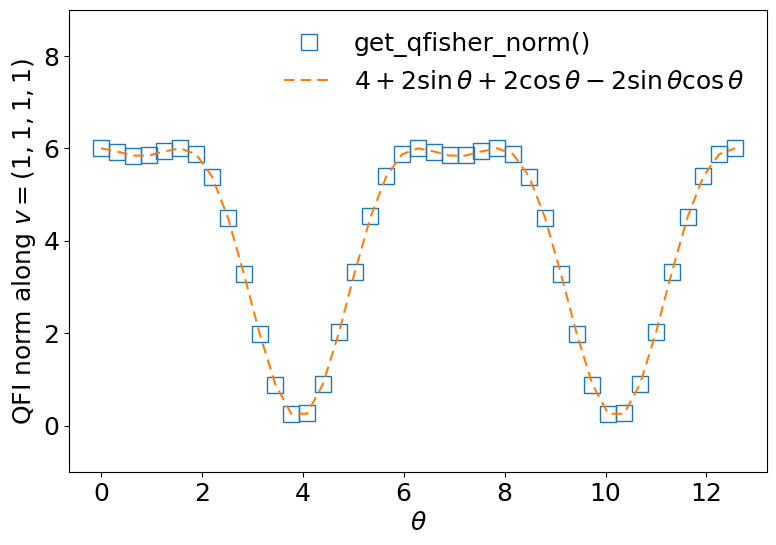

In [23]:
# 创建图像
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
# 绘制 QFIM 投影
ax.plot(thetas, list_qfisher_norm, 's', markersize=11, markerfacecolor='none')
analytical_qfi_norm = 4 + 2 * np.sin(thetas) + 2 * np.cos(thetas) - 2 * np.cos(thetas) * np.sin(thetas)
ax.plot(thetas, analytical_qfi_norm, linestyle=(0, (5, 3)))
# 设置图例，标签，刻度
ax.legend(
    ['get_qfisher_norm()', '$4+2\\sin\\theta+2\\cos\\theta-2\\sin\\theta\\cos\\theta$'], 
    loc='best', prop= {'size': label_font_size}, frameon=False,
)
ax.set_xlabel('$\\theta$', fontsize=label_font_size)
ax.set_ylabel('QFI norm along $v=(1,1,1,1)$', fontsize=label_font_size)
ax.set_ylim([-1, 9])
ax.tick_params(labelsize=label_font_size)

可以看到程序的输出和解析结果是一致的。

### 计算有效量子维数

利用量桨，我们可以通过调用 `get_eff_qdim()` 方法方便地计算有效量子维数（effective quantum dimension, EQD）。以下是上面提到的 hardware-efficient 拟设的 EQD 计算示例。

In [24]:
cir = circuit_hardeff_2qubit()
qf = QuantumFisher(cir)
print(cir)
print(f'The number of parameters is {len(cir.param.tolist())}.')
print(f'The EQD is {qf.get_eff_qdim()}. \n')

--Ry(5.101)----*----Ry(1.234)--
               |               
--Ry(5.941)----x----Ry(4.639)--
                               
The number of parameters is 4.
The EQD is 3. 



在这个例子中，EQD 比参数个数要少，这实际上可以通过控制电路上两个 $R_y$ 可以直接合并这一点上看出来。这可以通过替换其中一个 $R_y$ 门为 $R_x$ 门来修复，这会使得 EQD 增长 1。

如果继续在电路上增加门，EQD 会无限增长吗？答案显然是不会，这是因为对于 $n$ 个量子比特，量子态的实数自由度为 $2\cdot 2^n-2$，其中减 $2$ 是由于归一化和全局相位无关性这两条约束。这说明无论门的数量为多少，EQD 都不会超过 $2\cdot 2^n-2$。我们可以通过下面的例子做一简单的验证。

In [25]:
def circuit_hardeff_overparam():
    cir = Circuit(2)
    cir.ry()
    cir.rx()
    cir.cnot([0, 1])
    cir.ry()
    cir.rx()

    return cir


cir = circuit_hardeff_overparam()
qf = QuantumFisher(cir)
print(cir)
print(f'The number of parameters is {len(cir.param.tolist())}.')
print(f'The EQD is {qf.get_eff_qdim()}. \n')

--Ry(2.643)----Rx(4.541)----*----Ry(4.525)----Rx(2.093)--
                            |                            
--Ry(6.033)----Rx(5.897)----x----Ry(3.874)----Rx(5.445)--
                                                         
The number of parameters is 8.
The EQD is 6. 



### 计算经典费舍信息和有效维数

这里我们举一个简单的例子来展示如何利用量桨对于一个量子神经网络计算式 (16) 中的有效维数。

调用飞桨定义量子神经网络和相应的损失函数。

In [26]:
import paddle.nn as nn
from paddle_quantum.ansatz.layer import ComplexEntangledLayer
from paddle_quantum.gate import IQPEncoding, RX
from paddle_quantum.loss import ExpecVal
from paddle_quantum.hamiltonian import Hamiltonian
from paddle_quantum.state import zero_state

class QuantumNeuralNetwork(nn.Layer):
    def __init__(self, num_qubits, depth, encoding):
        super().__init__()
        self.num_qubits, self.encoding = num_qubits, encoding
        self.S = [[i, i + 1] for i in range(num_qubits - 1)]
        self.init_state = zero_state(num_qubits)
        self.loss_func = ExpecVal(Hamiltonian([[1.0, 'z0']]))
        
        if encoding == 'IQP':
            self.complex_layer = nn.LayerList([ComplexEntangledLayer(num_qubits=num_qubits, depth=depth)])
        elif encoding == 're-uploading':
            self.complex_layers = nn.LayerList([ComplexEntangledLayer(num_qubits=num_qubits) for _ in range(depth + 1)])
        else:
            raise RuntimeError('Non-existent encoding method')

    def forward(self, x):
        if not paddle.is_tensor(x):
            x = paddle.to_tensor(x, dtype='float32')

        state = self.init_state
        if self.encoding == 'IQP':
            state = IQPEncoding(x, qubits_idx=self.S)(state)
            state = self.complex_layer[0](state)
        else:
            for i in range(depth):
                state = self.complex_layers[i](state)
                for j in range(num_qubits):
                    state = RX(j, param=x[j].item())(state)
            state = self.complex_layers[depth](state)

        return self.loss_func(state) * 0.5 + 0.5

最后，定义 CFIM 计算器并计算不同大小的训练集对应的有效维数。

In [27]:
from paddle_quantum import set_backend

# 配置模型参数
num_qubits = 4
depth = 2
num_inputs = 100
num_thetas = 10
set_backend('state_vector')
# 定义 CFIM 计算器
cfim = ClassicalFisher(model=QuantumNeuralNetwork,
                       num_thetas=num_thetas,
                       num_inputs=num_inputs,
                       num_qubits=num_qubits,
                       depth=depth,
                       encoding='IQP')
# 计算归一化的 CFIM
fim, _ = cfim.get_normalized_cfisher()
# 计算不同样本大小对应的有效维数
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
effdim = cfim.get_eff_dim(fim, n)

running in get_gradient: 100%|##################################| 1000/1000 [00:29<00:00, 33.93it/s]


画出有效维数与参数个数之比随训练集大小的变化规律。

the number of parameters：24


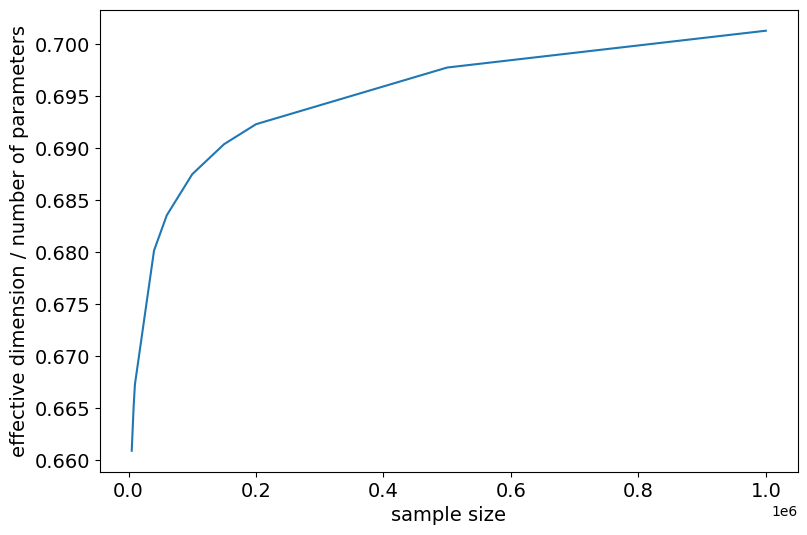

In [28]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
print('the number of parameters：%s' % cfim.num_params)
ax.plot(n, np.array(effdim) / cfim.num_params)
label_font_size = 14
ax.set_xlabel('sample size', fontsize=label_font_size)
ax.set_ylabel('effective dimension / number of parameters', fontsize=label_font_size)
ax.tick_params(labelsize=label_font_size)

## 总结

本教程从几何的角度简要介绍了经典费舍信息和量子费舍信息的概念及二者之间的关系，并以有效维数为例阐述了它们在量子机器学习中的应用，最后展示了如何调用量桨来具体地计算它们。

_______

## 参考文献

[1] Meyer, Johannes Jakob. "Fisher information in noisy intermediate-scale quantum applications." [arXiv preprint arXiv:2103.15191 (2021).](https://arxiv.org/abs/2103.15191)

[2] Haug, Tobias, Kishor Bharti, and M. S. Kim. "Capacity and quantum geometry of parametrized quantum circuits." [arXiv preprint arXiv:2102.01659 (2021).](https://arxiv.org/abs/2102.01659)

[3] Stokes, James, et al. "Quantum natural gradient." [Quantum 4 (2020): 269.](https://quantum-journal.org/papers/q-2020-05-25-269/)

[4] Mari, Andrea, Thomas R. Bromley, and Nathan Killoran. "Estimating the gradient and higher-order derivatives on quantum hardware." [Physical Review A 103.1 (2021): 012405.](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.012405)

[5] Datta, Nilanjana, and Felix Leditzky. "A limit of the quantum Rényi divergence." [Journal of Physics A: Mathematical and Theoretical 47.4 (2014): 045304.](https://iopscience.iop.org/article/10.1088/1751-8113/47/4/045304)

[6] Abbas, Amira, et al. "The power of quantum neural networks." [Nature Computational Science 1.6 (2021): 403-409.](https://www.nature.com/articles/s43588-021-00084-1)